In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('website_traffic.csv')
df.head()

,traffic
0,932
1,929
2,938
3,964
4,990


<AxesSubplot:>

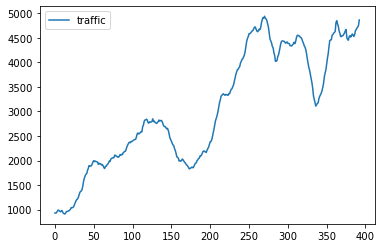

In [3]:
df.plot()

### Pre-processing Data

<AxesSubplot:>

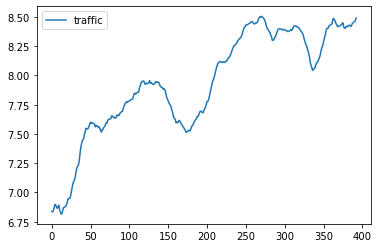

In [4]:
# transform data using log algorithm
df = np.log(df)
df.plot()

In [5]:
# split training and testing data
# using the last 10 days for testing
df_train = df[:-10]
df_test = df[-10:]

### Check for Stationarity

#### Method #1: Time Series Plot

For this example, it's easy to tell that the series is non-stationary from the above plot.

#### Method #2: ADF Test

In [6]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_train, autolag = 'AIC')

In [7]:
print(f'ADF Statistic: {dftest[0]}')
print(f'p-value: {dftest[1]}')
print(f'Number of Lags: {dftest[2]}')
for key, value in dftest[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.501857510368542
p-value: 0.1150230263520019
Number of Lags: 16
Critial Values:
   1%, -3.448343869853195
Critial Values:
   5%, -2.869469418606909
Critial Values:
   10%, -2.570994248260623


The p-value is greater than the significance level of 0.05 and hence we cannot reject the null hypothesis, which means the series is non-stationary.

### Transforming to Stationary by Differencing

<AxesSubplot:>

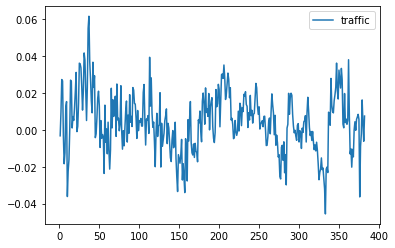

In [8]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

In [9]:
dftest = adfuller(df_train_diff, autolag = 'AIC')
print(f'p-value: {dftest[1]}')

p-value: 0.0038760896404456636


The p value shows that after the 1st order differencing, the transformed data is stationary. Hence, we could set the d=1 in ARIMA model.

### ARIMA Model

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  383
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1159.964
Date:                Sat, 06 Jan 2024   AIC                          -2311.928
Time:                        21:23:03   BIC                          -2296.146
Sample:                             0   HQIC                         -2305.667
                                - 383                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2256      0.123      9.945      0.000       0.984       1.467
ar.L2         -0.2780      0.103     -2.696      0.007      -0.480      -0.076
ma.L1         -0.7074      0.110     -6.415      0.0

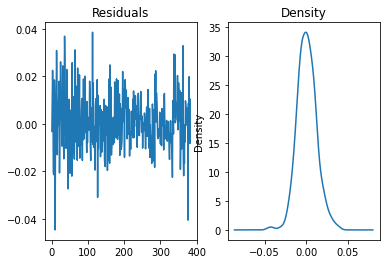

In [11]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

<AxesSubplot:>

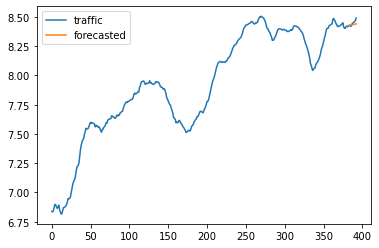

In [12]:
pred = model_fit.forecast(len(df_test))
df['forecasted'] = [None]*len(df_train) + list(pred)
df.plot()

### Auto ARIMA Model

In [13]:
import pmdarima as pm

In [14]:
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [15]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  383
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1164.591
Date:                Sat, 06 Jan 2024   AIC                          -2315.182
Time:                        21:23:08   BIC                          -2287.564
Sample:                             0   HQIC                         -2304.225
                                - 383                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      1.381      0.167      -0.000       0.002
ar.L1          0.5204      0.051     10.223      0.000       0.421       0.620
ar.L2          0.0877      0.061      1.426      0.154      -0.033       0.208
ar.L3         -0.0361      0.062     -0.582      0.560      -0.158       0.086
ar.L4          0.1188      0.052      2.292      0.022       0.017       0.220
ar.L5          0.1098      0.049      2.227      0.026       0.013       0.206
sigma2         0.0001   8.13e-06     16.147      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                14.76
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.09
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

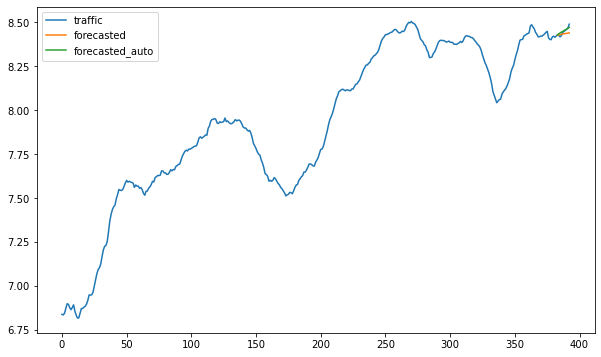

In [16]:
pred_auto = auto_arima.predict(n_periods=len(df_test))
df['forecasted_auto'] = [None]*len(df_train) + list(pred_auto)
df.plot(figsize=(10,6))

In [17]:
from sklearn.metrics import mean_squared_error
print(f'mean squared error of manual ARIMA model is: {mean_squared_error(df_test, pred)}')
print(f'mean squared error of auto ARIMA model is: {mean_squared_error(df_test, pred_auto)}')

mean squared error of manual ARIMA model is: 0.0004638436413645219
mean squared error of auto ARIMA model is: 0.00013370921628936741
